In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.imagenet_utils import decode_predictions
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
import glob
import time

In [4]:
folder = '/content/drive/My Drive/Projekt'
image_size = (224, 224)
batch_size = 32

In [5]:
def cleen_file():
  fileList = glob.glob('/content/drive/My Drive/Projekt/Figure/Predvidi/field*.jpg')
  print("Number of files: ",len(fileList))

  for filePath in fileList:
    try:
      os.remove(filePath)
    except:
      print("Error while deleting file : ", filePath)

In [6]:
def make64images(image):
  
  os.chdir('/content/drive/My Drive/Projekt')
  # Učitavanje slike šahovske ploče
  board = cv2.imread(image)
  # Izdvajanje visine i širine cijele ploče
  height, width = board.shape[:2]

  # Određivanje veličine jednog polja na ploči
  field_height = height // 8
  field_width = width // 8
  os.chdir('/content/drive/My Drive/Projekt/Figure/Predvidi')
  # Petlja za svako polje na ploči
  for row in range(8):
      for col in range(8):
          # Određivanje koordinata gornjeg lijevog kuta svakog polja
          y1 = row * field_height
          x1 = col * field_width
          y2 = y1 + field_height
          x2 = x1 + field_width
          
          # Izdvajanje slike polja
          field = board[y1:y2, x1:x2]
          
          # Spremanje slike polja
          cv2.imwrite("field_{}_{}.jpg".format(row, col), field)

In [7]:
def load_data():
  datagen = ImageDataGenerator(
          rotation_range=5,
          width_shift_range=0.1,
          height_shift_range=0.1,
          rescale=1./255,
          horizontal_flip=True,
          fill_mode='nearest'
          )

  test_datagen = ImageDataGenerator(rescale=1./255)


  train_gen = datagen.flow_from_directory(
      folder + '/Train',
      target_size = image_size,
      batch_size = batch_size,
      class_mode = 'categorical',
      color_mode = 'rgb',
      shuffle=True  
  )

  test_gen = test_datagen.flow_from_directory(
      folder + '/Test',
      target_size = image_size,
      batch_size = batch_size,
      class_mode = 'categorical',
      color_mode = 'rgb',
      shuffle=False 
  )
  test = test_datagen.flow_from_directory(
      folder + '/Figure',
      target_size = image_size,
      batch_size = batch_size,
      class_mode = 'categorical',
      color_mode = 'rgb',
      shuffle=False 
  )
  return train_gen,test_gen,test

# Novi odjeljak

In [8]:
def train_model(train_gen,test_gen):
  
  model = VGG16(weights='imagenet')
  model.summary()

  base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3)) 
  
  # Freeze convolutional layers
  for layer in base_model.layers:
      layer.trainable = False    

  # Establish new fully connected block
  x = base_model.output
  x = Flatten()(x)  # flatten from convolution tensor output  
  x = Dense(500, activation='relu')(x) # number of layers and units are hyperparameters, as usual
  x = Dense(500, activation='relu')(x)
  predictions = Dense(13, activation='softmax')(x) # should match # of classes predicted

  # this is the model we will train
  model = Model(inputs=base_model.input, outputs=predictions)
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

  epochs = 10

  history = model.fit(
      train_gen, 
      epochs=epochs,
      verbose = 1,
      validation_data=test_gen
      )
  model.save_weights('model_VGG16.h5') 

  plt.plot(history.history['categorical_accuracy'], 'ko')
  plt.plot(history.history['val_categorical_accuracy'], 'b')

  plt.title('Accuracy vs Training Epoch')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(['Train', 'Validation']);
  return model

In [9]:

def make_confusion_matrix(test_gen,model):
  target_names = ['BB', 'BK', 'BN', 'BP', 'BQ', 'BR', 'Empty', 'WB', 'WK', 'WN', 'WP', 'WQ', 'WR']

  test_gen.reset()
  Y_pred = model.predict_generator(test_gen)
  classes = test_gen.classes[test_gen.index_array]
  y_pred = np.argmax(Y_pred, axis= -1)
  print(sum(y_pred==classes)/800)


  data = confusion_matrix(classes, y_pred)
  df_cm = pd.DataFrame(data, columns=target_names, index = target_names)
  df_cm.index.name = 'Actual'
  df_cm.columns.name = 'Predicted'
  plt.figure(figsize = (20,14))
  sn.set(font_scale=1.4)#for label size
  sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

  #print(classes)
  #print(y_pred)

  print('Confusion Matrix')
  print(data)
  print('Classification Report')
  print(classification_report(test_gen.classes[test_gen.index_array], y_pred, target_names=target_names))

In [10]:
def write_fen(model,test):
  Y_pred = model.predict(test)
  y_pred = np.argmax(Y_pred, axis= -1)
  print(y_pred)
  broj = 0
  br_string = 0
  stringovi = []
  figure = ["b","k","n","p","q","r","-","B","K","N","P","Q","R"]
  string = ""
  for i in (y_pred):
    #print(broj, " ", figure[i])
    if i == 6:
      broj += 1
    else:
      if broj > 0:
        string += str(broj)
        broj = 0
      string += figure[i]
    br_string += 1
    if br_string > 7:
      if broj > 0:
        string += str(broj)
      stringovi.append(string)
      broj = 0
      string = ""
      br_string = 0
  fen = ""
  for i in range (len(stringovi)):
    fen += stringovi[i]
    if i < 7:
      fen += "/"
  return fen

In [12]:
def BoardToFen(image):
  cleen_file()
  time.sleep(5)
  make64images(image)
  time.sleep(5)
  train,test_val,test = load_data()
  fen = write_fen(model,test)
  print(fen) 
  return fen

In [52]:
def fen_to_image(fen):
  os.chdir('/content/drive/My Drive/Projekt/pics')
  pieces = {"p": "_black_pawn.png", "n": "_black_knight.png", "b": "_black_bishop.png", "r": "_black_rook.png", "q": "_black_queen.png", "k": "_black_king.png",
                "P": "white_pawn.png", "N": "white_knight.png", "B": "white_bishop.png", "R": "white_rook.png", "Q": "white_queen.png", "K": "white_king.png"}
  fen = fen.split("/")
  plt.ioff()
  fig, ax = plt.subplots()
  for i in range(8):
      for j in range(8):
          if (i + j) % 2 == 0:
              ax.add_patch(plt.Rectangle((i, j), 1, 1, color=(238/255, 238/255, 210/255)))
          else:
              ax.add_patch(plt.Rectangle((i, j), 1, 1, color=(117/255, 150/255, 85/255)))
  plt.xlim(0, 8 )
  plt.ylim(0, 8 )
  y = 8
  for i in range (8):
    y += -1
    x = 0
    for j in fen[i]:
      if j.isdigit():
        x += int(j)
      else:
        img = mpimg.imread(pieces[j])
        ax.imshow(img, extent=(x, x+1, y, y+1), zorder=1)
        x += 1
  fig.set_size_inches(50,50)
  os.chdir('/content/drive/My Drive/Projekt')
  plt.savefig("sah_2d", facecolor = "none", bbox_inches='tight', pad_inches=0)
  plt.close(fig)
  

In [56]:
def Chess_board_3d_to_2d(image):
  os.chdir('/content/drive/My Drive/Projekt')

  fig = plt.figure()

  fen = BoardToFen(image)
  fen_to_image(fen)
  os.chdir('/content/drive/My Drive/Projekt')
  ax1 = fig.add_subplot(122)
  imageshow = mpimg.imread("sah_2d.png")
  plt.axis('off')
  ax1.imshow(imageshow)

  ax2 = fig.add_subplot(121)
  imageshow = mpimg.imread(image)
  plt.axis('off')
  ax2.imshow(imageshow)

  fig.set_size_inches(20,20)

  plt.show()

Found 406 images belonging to 13 classes.
Found 215 images belonging to 13 classes.
Found 64 images belonging to 1 classes.
553467096/553467096 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 b

<ipython-input-9-b25ad220471a>:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_gen)


0.26375
Confusion Matrix
[[20  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 20  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 20  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 20  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 20  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  4  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  5  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 20  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 20  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 20  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 20  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 20  0]
 [ 0  0  0  0  0  3  0  0  0  0  0  0  2]]
Classification Report
              precision    recall  f1-score   support

          BB       1.00      1.00      1.00        20
          BK       1.00      1.00      1.00        20
          BN       1.00      1.00      1.00        20
          BP       1.00      1.00      1.00        20
          BQ       1.00      1.00      1.00        20
          BR       0.57      0.80      0.67         5
       Empty       0.83    

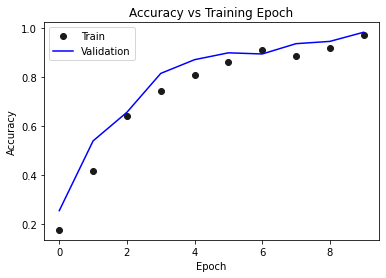

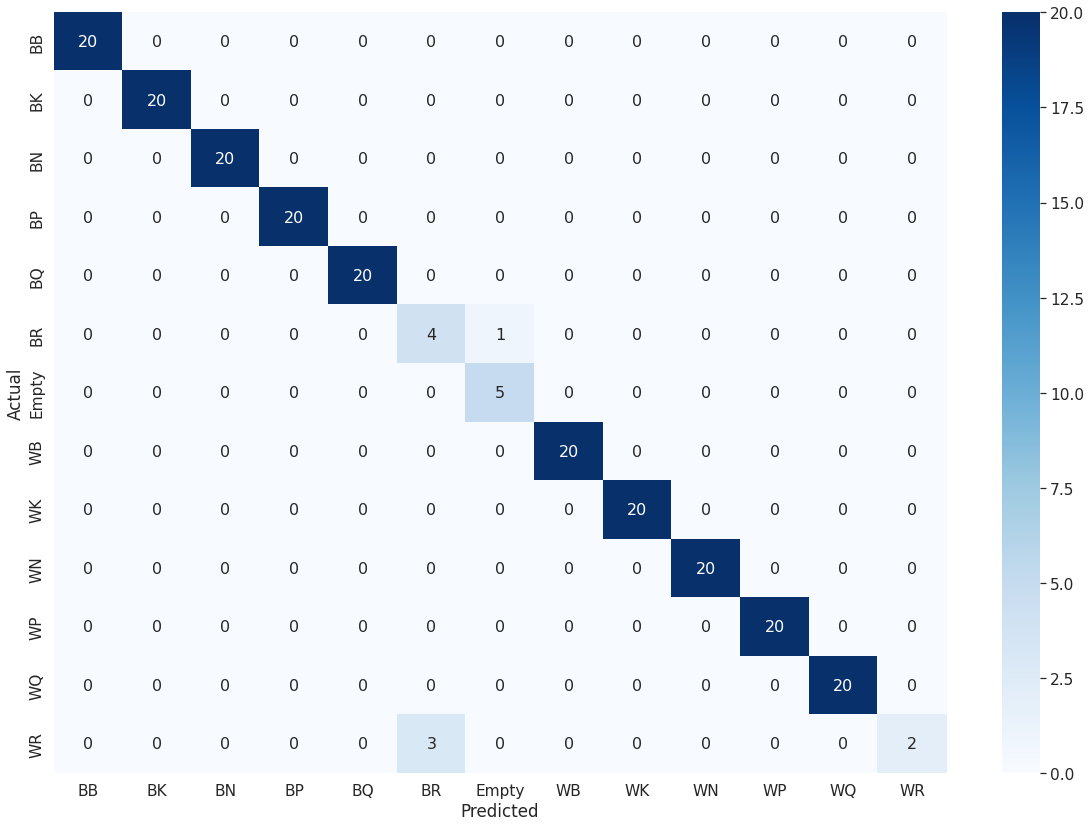

In [11]:
train,test_val,test = load_data()
model = train_model(train,test_val)
make_confusion_matrix(test_val,model)

Number of files:  64
Found 406 images belonging to 13 classes.
Found 215 images belonging to 13 classes.
Found 64 images belonging to 1 classes.
2/2 [==============================] - 0s 193ms/step
[ 5  5  5  5  5  5  5 12 12  5 12 12 12 12 12 12  6  6  6  6  6  6  6  6
  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6
  5  5  5 12  5  5  5 12  5  5 12  5  5 12  5  5]
rrrrrrrR/RrRRRRRR/8/8/8/8/rrrRrrrR/rrRrrRrr


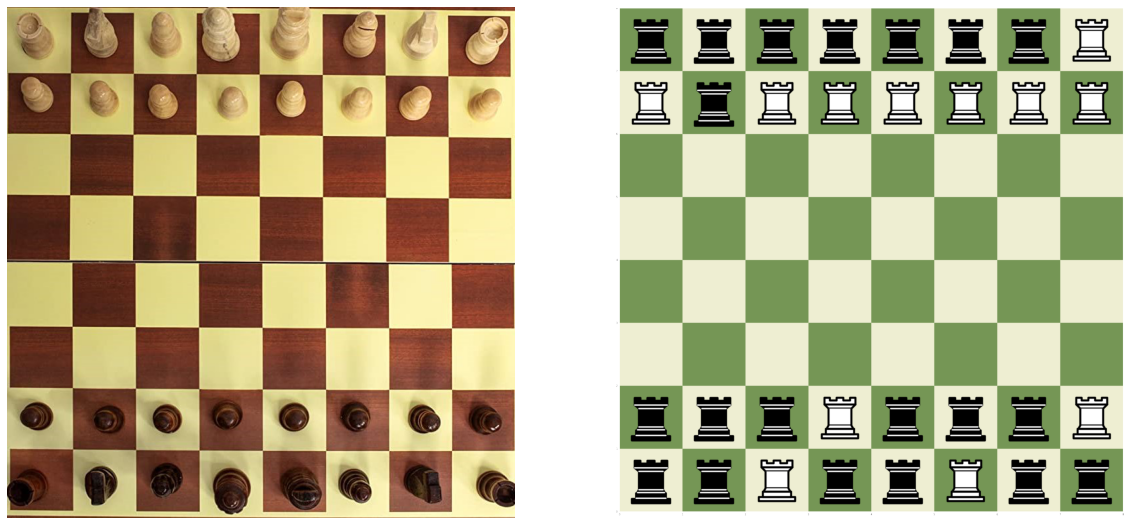

In [57]:
Chess_board_3d_to_2d("aaa2.jpg")